<a href="https://colab.research.google.com/github/karon999/Database/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3

* Assigned: 10/10

* Due: 10/29 @ 11:59PM ET on Gradescope

* Value: 3.75% of your grade

In this assignment it's time to get real! You'll first flex your SQL muscles and perform analyses similar to HW2's by writing SQL and reflecting on the experience. You will then perform some normalization.

# Assignment description

In this assignment, we will explore how to train a decision tree model over joins using SQL and implement some core functions in training the model. We will break down the steps into smaller problems.

Each decision tree can be understood as a set of (`condition`, `prediction`) pairs that assign a `prediction` to rows in the dataset satisfying the `condition`. To train a decision tree model, we learn the `condition` by iteratively splitting the dataset. In this homework, we consider the equal/not equal split based on a `value` for each `attribute`. That is, each `condition` will be of the form `attribute == value` and `attribute != value`.

For the split criteria, we will consider minimizing variance for each split. To compute variance of an attribute, we use the formula $Var(X) = \frac{1}{n}\sum (x_i - \bar{x})^2$. For the target variable $Y$, we would like to find the best (`attribute`, `value`) pair such that the $Var(Y)$ subtracting the sum of $Var(Y)$ in the dataset satisfying `attribute == value` and `attribute != value` is maximized.

We will also be using [DuckDB](https://duckdb.org/), a new database system designed for analytics.  It is very similar to the SQLite database we have used in the past, however it is _must faster_ when analyzing the entire dataset.

# Setup

We will use 2 tables from the favorita database (out of the 7 tables): `sales` is a fact table containing sales facts. `items` is a dimension table where the `item_nbr` in `sales` refer to that in `items`. Therefore, joining `sales` with `items` will lead to a table with the same number of tuples as that in `sales`.

We would like to write the core functions that trains a decision tree model to predict the `unit_sales` attribute in the `sales` table using the `family` attribute in `items`.

In [5]:
!pip install duckdb

In [6]:
import duckdb

con = duckdb.connect(database=':memory:')
con.execute("CREATE OR REPLACE TABLE items AS SELECT * FROM 'items.csv';")
con.execute("CREATE OR REPLACE TABLE sales AS SELECT * FROM 'sales.csv';")

def runq(q):
    "I'm helper function to run and print queries"
    cursor = con.execute(q)
    df = cursor.fetchdf()
    return df

# Question 1

We will first discuss the naive approach where we materialize the join and compute the variance over the target variable for a potential split. We will consider the `family` attribute in `items` as an example. For each split $\sigma_{family=value}$ and $\sigma_{family\ne value}$, we will need to compute the variance of the target variable.

## 1.1
To compute the variance, one important statistics we need is the mean of `unit_sales` for $\sigma_{family=value}$ and $\sigma_{family\ne value}$ for each $value$ in the domain of `items.family`. Write a query to compute the mean of `unit_sales` for $\sigma_{family=value}$ and $\sigma_{family\ne value}$ for each `family`.

In [33]:
q11 = """
WITH distinct_families AS (
    SELECT DISTINCT family FROM items
),
family_stats AS (
    SELECT f.family AS family,
        AVG(s.unit_sales) AS avg_sales_family
    FROM sales s, items i, distinct_families f
    WHERE s.item_nbr = i.item_nbr AND i.family = f.family
    GROUP BY f.family
),
notfamily_stats AS (
    SELECT f.family AS family,
        AVG(s.unit_sales) AS avg_sales_notfamily
    FROM sales s, items i, distinct_families f
    WHERE s.item_nbr = i.item_nbr AND i.family != f.family
    GROUP BY f.family
)
SELECT family_stats.family,
    family_stats.avg_sales_family,
    notfamily_stats.avg_sales_notfamily
FROM family_stats, notfamily_stats
WHERE family_stats.family = notfamily_stats.family
ORDER BY family_stats.family
"""
runq(q11)

,family,avg_sales_family,avg_sales_notfamily
0,AUTOMOTIVE,1.755814,8.574798
1,BABY CARE,2.045455,8.557492
2,BEAUTY,1.870504,8.566513
3,BEVERAGES,12.276050,7.949025
4,BOOKS,1.900000,8.557339
5,BREAD/BAKERY,9.122976,8.535281
6,CELEBRATION,2.060959,8.576230
7,CLEANING,5.733923,9.000439
8,DAIRY,7.186554,8.663158
9,DELI,5.846958,8.648745


## 1.2
To compute the best split, we need to compute the maximum reduction in variance for each potential split point ($\sigma_{family=value}$ and $\sigma_{family\ne value}$). Modify your query in 1.1 to compute the sum of variance of `unit_sales` in $\sigma_{family=value}$ and $\sigma_{family\ne value}$.

In [37]:
q12 = """
WITH distinct_families AS (
    SELECT DISTINCT family FROM items
),
family_stats AS (
    SELECT f.family AS family,
        VAR_POP(s.unit_sales) AS var_sales_family
    FROM sales s, items i, distinct_families f
    WHERE s.item_nbr = i.item_nbr AND i.family = f.family
    GROUP BY f.family
),
notfamily_stats AS (
    SELECT f.family AS family,
        VAR_POP(s.unit_sales) AS var_sales_notfamily
    FROM sales s, items i, distinct_families f
    WHERE s.item_nbr = i.item_nbr AND i.family != f.family
    GROUP BY f.family
)
SELECT family_stats.family,
    family_stats.var_sales_family,
    notfamily_stats.var_sales_notfamily,
    family_stats.var_sales_family + notfamily_stats.var_sales_notfamily AS sum_of_variance
FROM family_stats, notfamily_stats
WHERE family_stats.family = notfamily_stats.family
ORDER BY family_stats.family
"""
runq(q12)

,family,var_sales_family,var_sales_notfamily,sum_of_variance
0,AUTOMOTIVE,1.868280,375.337908,377.206188
1,BABY CARE,1.316116,374.508568,375.824684
2,BEAUTY,2.351576,374.949688,377.301264
3,BEVERAGES,767.800086,307.541032,1075.341118
4,BOOKS,3.690000,374.500543,378.190543
5,BREAD/BAKERY,170.050343,382.403662,552.454005
6,CELEBRATION,5.601079,375.450385,381.051463
7,CLEANING,122.077836,412.673576,534.751411
8,DAIRY,92.614945,396.126993,488.741938
9,DELI,64.420646,384.710425,449.131071


## 1.3
Next, compute the maximum reduction in variance and select the best split point. i.e. the value of `family`.

In [43]:
q13 = """
WITH total_variance AS (
    SELECT VAR_POP(sales.unit_sales) AS total_var FROM sales
),
distinct_families AS (
    SELECT DISTINCT family FROM items
),
family_stats AS (
    SELECT f.family AS family,
        VAR_POP(s.unit_sales) AS var_sales_family
    FROM sales s, items i, distinct_families f
    WHERE s.item_nbr = i.item_nbr AND i.family = f.family
    GROUP BY f.family
),
notfamily_stats AS (
    SELECT f.family AS family,
        VAR_POP(s.unit_sales) AS var_sales_notfamily
    FROM sales s, items i, distinct_families f
    WHERE s.item_nbr = i.item_nbr AND i.family != f.family
    GROUP BY f.family
)
SELECT family_stats.family,
    family_stats.var_sales_family,
    notfamily_stats.var_sales_notfamily,
    family_stats.var_sales_family + notfamily_stats.var_sales_notfamily AS sum_of_variance,
    total_variance.total_var - (family_stats.var_sales_family + notfamily_stats.var_sales_notfamily) AS variance_reduction
FROM family_stats, notfamily_stats, total_variance
WHERE family_stats.family = notfamily_stats.family
ORDER BY variance_reduction DESC
"""
runq(q13)

,family,var_sales_family,var_sales_notfamily,sum_of_variance,variance_reduction
0,HOME APPLIANCES,0.910400,374.559171,375.469571,-0.975558
1,HARDWARE,0.923731,374.669068,375.592799,-1.098786
2,BABY CARE,1.316116,374.508568,375.824684,-1.330670
3,AUTOMOTIVE,1.868280,375.337908,377.206188,-2.712175
4,BEAUTY,2.351576,374.949688,377.301264,-2.807251
5,BOOKS,3.690000,374.500543,378.190543,-3.696530
6,PET SUPPLIES,3.911206,374.912392,378.823598,-4.329585
7,LADIESWEAR,3.876932,375.214086,379.091017,-4.597004
8,LINGERIE,4.715307,375.290208,380.005514,-5.511501
9,PLAYERS AND ELECTRONICS,5.171081,375.154865,380.325946,-5.831933


# Question 2

Note that the approach above requires materializing the join. However, `item` is way smaller than `sales` so if we naively join the two tables together, rows in the `item` table will be duplicated. To do better, we may exploit a technique called $\textit{factorized learning}$. In Q4 from the last homework, we see that for two tables `R` and `S` we may pre-aggregate the sum of `X` in `R` group by `A` and the count in `S` group by `A`, and use them to compute the sum of `R.X` in the join in $R \Join_A S$. Here, we will use a similar technique to avoid materializing the join.

Based on the fact that $Var(X) = \frac{1}{n}\sum (x_i - \bar{x})^2 = \frac{1}{n} \left(\sum x_i^2 - \bar{x}\sum x_i\right)$ for a random variable $X$, we need to compute $Var(sales)$ when `family` is equal to some value and `family` not equal to that value ($\bar{x}$ is mean of `sales` in both cases, respectively). Following the strategies in HW2 Q4, we may apply pre-aggregating by breaking down $Var(X)$ into $\sum x_i^2 - \bar{x}\sum x_i$ for each `family`.

## 2.1
Write a query to pre-aggregate `sales` and `item` to compute the count of all rows in `sales` join `items` for each `family` and `item_nbr` pair. You will create (1) a table containing `item_nbr` and another column for `sales`, (2) a table containing `item_nbr`, `family`, and another column for `items`, and (3) your select statement.

In [10]:
q21_part1 = """
CREATE OR REPLACE TABLE sales_count AS
SELECT item_nbr,
    COUNT(*) AS sales_count
FROM sales
GROUP BY item_nbr
"""

q21_part2 = """
CREATE OR REPLACE TABLE items_family AS
SELECT item_nbr,
    family
FROM items
GROUP BY item_nbr, family
"""

q21_part3 = """
SELECT i.item_nbr,
    i.family,
    s.sales_count
FROM sales_count s, items_family i
WHERE s.item_nbr = i.item_nbr
"""

runq(q21_part1)
runq(q21_part2)
runq(q21_part3)

,item_nbr,family,sales_count
0,103665,BREAD/BAKERY,188
1,105575,GROCERY I,150
2,108634,GROCERY I,56
3,108696,DELI,228
4,108797,GROCERY I,297
...,...,...,...
3993,1353191,GROCERY I,100
3994,1363877,GROCERY I,34
3995,732007,DELI,271
3996,1576323,CELEBRATION,74


## 2.2
Write a query to pre-aggregate `sales` and `item` to compute the sum of `unit_sales` in `sales` join `items` for each `family` and `item_nbr` pair. You will create (1) a table containing `item_nbr` and another column for `sales`, (2) a table containing `item_nbr`, `family`, and another column for `items`, and (3) your select statement. (The extra columns you created in this question can be the same as that in 2.1)

In [11]:
q22_part1 = """
CREATE OR REPLACE TABLE sales_sum AS
SELECT item_nbr,
    SUM(unit_sales) AS sales_sum
FROM sales
GROUP BY item_nbr
"""

q22_part2 = """
CREATE OR REPLACE TABLE items_family AS
SELECT item_nbr,
    family
FROM items
GROUP BY item_nbr, family
"""

q22_part3 = """
SELECT i.item_nbr,
    i.family,
    s.sales_sum
FROM sales_sum s, items_family i
WHERE s.item_nbr = i.item_nbr
"""

runq(q22_part1)
runq(q22_part2)
runq(q22_part3)

,item_nbr,family,sales_sum
0,103665,BREAD/BAKERY,851.0
1,105575,GROCERY I,3127.0
2,105737,GROCERY I,933.0
3,108634,GROCERY I,238.0
4,108696,DELI,1059.0
...,...,...,...
3993,1353191,GROCERY I,265.0
3994,1363877,GROCERY I,147.0
3995,732007,DELI,1012.0
3996,1576323,CELEBRATION,181.0


## 2.3
Write a query to pre-aggregate `sales` and `item` to compute the sum of square of `unit_sales` in `sales` join `items` for each `family` and `item_nbr` pair. You will create (1) a table containing `item_nbr` and another column for `sales`, (2) a table containing `item_nbr`, `family`, and another column for `items`, and (3) your select statement (The extra columns you created in this question can be the same as that in 2.1 and 2.2)

In [14]:
q23_part1 = """
CREATE OR REPLACE TABLE sales_sum_square AS
SELECT item_nbr,
    SUM(unit_sales * unit_sales) AS sales_sum_square
FROM sales
GROUP BY item_nbr
"""

q23_part2 = """
CREATE OR REPLACE TABLE items_family AS
SELECT item_nbr,
    family
FROM items
GROUP BY item_nbr, family
"""

q23_part3 = """
SELECT i.item_nbr,
    i.family,
    s.sales_sum_square
FROM sales_sum_square s, items_family i
WHERE s.item_nbr = i.item_nbr
"""

runq(q23_part1)
runq(q23_part2)
runq(q23_part3)

,item_nbr,family,sales_sum_square
0,103665,BREAD/BAKERY,6821.0
1,105575,GROCERY I,124295.0
2,105737,GROCERY I,12521.0
3,108634,GROCERY I,3346.0
4,108696,DELI,9781.0
...,...,...,...
3993,1464196,BEVERAGES,1074.0
3994,1353191,GROCERY I,1195.0
3995,1576323,CELEBRATION,607.0
3996,732007,DELI,6912.0


## 2.4
Combining your solutions for 2.1, 2.2 and 2.3, you may pre-aggregate `sales` and `item` and only use the pre-aggregations to compute (write a query) the count of rows, sum of `unit_sales`, and sum of square of `unit_sales` for each `family`.

In [76]:
q24 = """
CREATE OR REPLACE TABLE stats AS
SELECT i.family,
    COUNT(*) AS row_count,
    SUM(s.sales_sum) AS sum_sales,
    SUM(sq.sales_sum_square) AS sum_sales_square
FROM items_family i, sales_sum s, sales_sum_square sq
WHERE i.item_nbr = s.item_nbr AND i.item_nbr = sq.item_nbr
GROUP BY i.family
ORDER BY i.family
"""
runq(q24)

,family,row_count,sum_sales,sum_sales_square
0,AUTOMOTIVE,20,2.265000e+03,6.387000e+03
1,BABY CARE,1,4.500000e+01,1.210000e+02
2,BEAUTY,19,1.300000e+03,4.066000e+03
3,BEVERAGES,599,8.627240e+05,6.454953e+07
4,BOOKS,1,1.900000e+01,7.300000e+01
5,BREAD/BAKERY,134,1.701709e+05,4.724414e+06
6,CELEBRATION,31,3.009000e+03,1.437900e+04
7,CLEANING,445,3.890180e+05,1.051297e+07
8,DAIRY,242,2.578320e+05,5.175670e+06
9,DELI,91,9.551591e+04,1.610853e+06


## 2.5
Using your solution 2.4, write a query to compute variance of `unit_sales` for each `family`.

In [77]:
q25 = """
SELECT family,
    sum_sales_square - sum_sales * sum_sales / row_count AS variance_unit_sales
FROM stats
ORDER BY family
"""
runq(q25)

,family,variance_unit_sales
0,AUTOMOTIVE,-2.501242e+05
1,BABY CARE,-1.904000e+03
2,BEAUTY,-8.488137e+04
3,BEVERAGES,-1.178009e+09
4,BOOKS,-2.880000e+02
5,BREAD/BAKERY,-2.113810e+08
6,CELEBRATION,-2.776881e+05
7,CLEANING,-3.295657e+08
8,DAIRY,-2.695241e+08
9,DELI,-9.864507e+07


## 2.6
Similarly, using your solution 2.4, write a query to compute variance of the `unit_sales` whose `family` values does not equal to each `family` values.

In [80]:
q26 = """
SELECT s1.family,
    SUM(s2.sum_sales_square) - SUM(s2.sum_sales) * SUM(s2.sum_sales) / SUM(s2.row_count) AS variance_unit_sales_notfamily
FROM stats s1, stats s2
WHERE s1.family != s2.family
GROUP BY s1.family
ORDER BY s1.family

"""
runq(q26)

,family,variance_unit_sales_notfamily
0,AUTOMOTIVE,-4.373196e+09
1,BABY CARE,-4.356089e+09
2,BEAUTY,-4.374113e+09
3,BEVERAGES,-3.273531e+09
4,BOOKS,-4.356145e+09
5,BREAD/BAKERY,-4.149191e+09
6,CELEBRATION,-4.384347e+09
7,CLEANING,-4.044708e+09
8,DAIRY,-4.085522e+09
9,DELI,-4.256434e+09


## (Extra credits: 3 points) Q3: Write a short paragraph about the main differences between writing Python code and writing SQL. List one pro and one con for each approach.

In [81]:
{
    "Pros": "SQL is designed to interact with databases and is optimized for database processing, making data insertion and retrieval faster and more efficient, especially when working with large-scale data. In addition, SQL effectively manages user rights. By assigning different levels of access, SQL ensures that only authorized users can view or modify specific data, enhancing the overall security of the database and protecting sensitive information.",
    "Cons": "While SQL is powerful for databases, it lacks flexibility for more advanced data manipulation, controlling operations outside the scope of the database. Tasks such as data transformation and multi-step logic often require additional programming languages such as Python."
}

{'Pros': 'SQL is designed to interact with databases and is optimized for database processing, making data insertion and retrieval faster and more efficient, especially when working with large-scale data. In addition, SQL effectively manages user rights. By assigning different levels of access, SQL ensures that only authorized users can view or modify specific data, enhancing the overall security of the database and protecting sensitive information.',
 'Cons': 'While SQL is powerful for databases, it lacks flexibility for more advanced data manipulation, controlling operations outside the scope of the database. Tasks such as data transformation and multi-step logic often require additional programming languages such as Python.'}

# Submit Your Results

Clean up your codes and double check that:

1.   Your result is reproducible. You may want to restart runtime (Ctrl M .) and run all the codes again (Ctrl F9).
2.   You don't use any modules beyond [Python Standard Library](https://docs.python.org/3/library/).
3.   You don't run any operating system shell command (prepended by exclamation point) besides the setup codes we provided.
4. Your `results` variable's format is not different from what was given in the base code.

After that, save your notebook as a python file:

1.   Click on the "file" on the top toolbar.
2.   Click on the "Download" then "Download .py" (Note that not "Download .ipynb").
3.   Name the file "hw3.py" and download the file to your local storage.
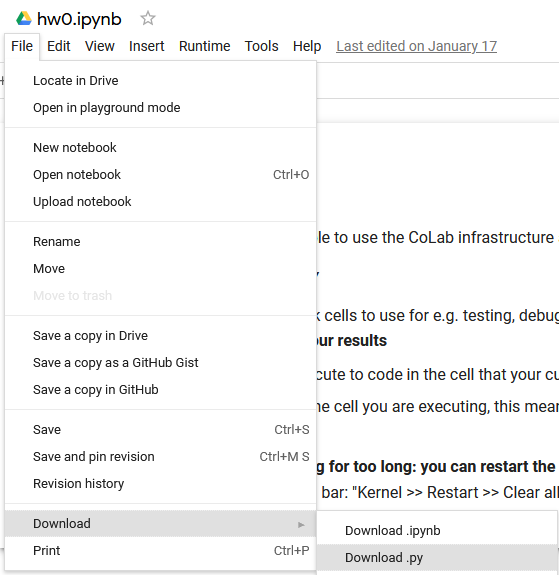

Upload the "hw3.py" to Gradescope "HW3 Programming." We have tests to check that your .py file is executable. Make sure you pass the first two tests.